In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [21]:
# CONFIGURATION 
dataset = "C:/Users/eesha/OneDrive/Documents/ML/Final Project/data/FF++"
real_vids = os.path.join(dataset, "real")
fake_vids = os.path.join(dataset, "fake")
demo_vid = os.path.join(real_vids, "C:/Users/eesha/OneDrive/Documents/ML/Final Project/data/FF++/real/01__kitchen_still.mp4")
MODEL_DIR = "saved_models"
MAX_SAMPLES = 200  # 100 real + 100 fake

os.makedirs(MODEL_DIR, exist_ok=True)

In [22]:
# MODEL & TRANSFORM 
cnn_model = models.mobilenet_v2(pretrained=True).features.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


c:\Users\eesha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\eesha\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# FRAME & FEATURE EXTRACTORS 
def extract_frames(video_path, max_frames=8):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, total_frames // max_frames)
    for i in range(max_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_step)
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def extract_features(frames):
    features = []
    for frame in frames:
        try:
            input_tensor = transform(frame).unsqueeze(0)
            with torch.no_grad():
                embedding = cnn_model(input_tensor).squeeze().mean([1, 2]).numpy()
            features.append(embedding)
        except Exception:
            continue
    return np.mean(features, axis=0) if features else None


In [24]:
# DATA PROCESSING 
def process_dataset(max_samples=MAX_SAMPLES):
    X, y = [], []
    for label, video_dir in enumerate([real_vids, fake_vids]):
        label_name = "REAL" if label == 0 else "FAKE"
        if not os.path.exists(video_dir):
            print(f"Warning: Directory not found: {video_dir}")
            continue
        video_files = [f for f in os.listdir(video_dir) if f.lower().endswith(('.mp4', '.avi'))][:max_samples // 2]
        for video_file in tqdm(video_files, desc=f"Processing {label_name}"):
            video_path = os.path.join(video_dir, video_file)
            frames = extract_frames(video_path)
            features = extract_features(frames)
            if features is not None:
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

In [25]:
# TRAINING AND EVALUATION
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_auc_score, roc_curve, classification_report
)
import seaborn as sns

def train_all_models(X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.pkl"))

    models_dict = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(probability=True)
    }

    results = {}
    for name, model in models_dict.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_proba = model.predict_proba(X_val_scaled)[:, 1]
        
        # Evaluation metrics
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_proba)
        
        results[name] = {
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "AUC": auc
        }
        
        # Save the model
        joblib.dump(model, os.path.join(MODEL_DIR, f"{name.lower().replace(' ', '_')}.pkl"))

        print(f"\n{name} - Evaluation Metrics:")
        print(f"Accuracy: {acc:.2f}")
        print(f"Precision: {prec:.2f}")
        print(f"Recall: {rec:.2f}")
        print(f"F1-Score: {f1:.2f}")
        print(f"AUC Score: {auc:.2f}")
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_val, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Plot accuracy comparison
    plt.bar(results.keys(), [v['Accuracy'] for v in results.values()], color='skyblue')
    plt.ylabel("Validation Accuracy")
    plt.title("Model Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [26]:
# PREDICTION 
def predict_video(video_path):
    scaler_path = os.path.join(MODEL_DIR, "scaler.pkl")
    if not os.path.exists(scaler_path):
        print("Scaler not found. Train models first.")
        return

    scaler = joblib.load(scaler_path)
    frames = extract_frames(video_path)
    features = extract_features(frames)
    if features is None:
        print("No features extracted.")
        return

    input_scaled = scaler.transform([features])

    model_files = {
        "Logistic Regression": "logistic_regression.pkl",
        "Decision Tree": "decision_tree.pkl",
        "Random Forest": "random_forest.pkl",
        "KNN": "knn.pkl",
        "SVM": "svm.pkl"
    }

    predictions = {}
    for name, filename in model_files.items():
        model_path = os.path.join(MODEL_DIR, filename)
        if not os.path.exists(model_path):
            print(f"Model not found: {filename}")
            continue
        model = joblib.load(model_path)
        probs = model.predict_proba(input_scaled)[0]
        label_idx = np.argmax(probs)
        label = "FAKE" if label_idx == 1 else "REAL"
        margin_conf = np.sort(probs)[-1] - np.sort(probs)[-2]
        predictions[name] = (label, margin_conf)

    print("\n--- Model Predictions ---")
    for name, (label, conf) in predictions.items():
        print(f"{name}: {label} ({conf*100:.2f}% margin confidence)")

    # Show sample frames
    plt.figure(figsize=(12, 4))
    for i, frame in enumerate(frames[:4]):
        plt.subplot(1, 4, i+1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1}")
        plt.axis("off")
    plt.suptitle("Sample Video Frames")
    plt.tight_layout()
    plt.show()


Processing FAKE: 100%|██████████| 100/100 [01:16<00:00,  1.31it/s]



Logistic Regression - Evaluation Metrics:
Accuracy: 0.68
Precision: 0.62
Recall: 0.79
F1-Score: 0.70
AUC Score: 0.55

Confusion Matrix:
[[12  9]
 [ 4 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.65        21
           1       0.62      0.79      0.70        19

    accuracy                           0.68        40
   macro avg       0.69      0.68      0.67        40
weighted avg       0.69      0.68      0.67        40


Decision Tree - Evaluation Metrics:
Accuracy: 0.68
Precision: 0.62
Recall: 0.79
F1-Score: 0.70
AUC Score: 0.68

Confusion Matrix:
[[12  9]
 [ 4 15]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.57      0.65        21
           1       0.62      0.79      0.70        19

    accuracy                           0.68        40
   macro avg       0.69      0.68      0.67        40
weighted avg       0.69      0.68      0.67    

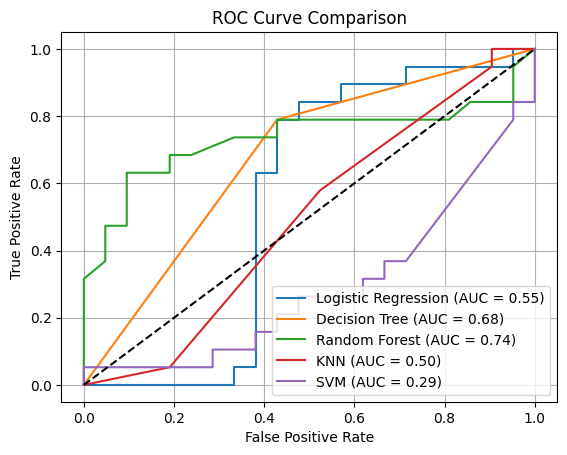

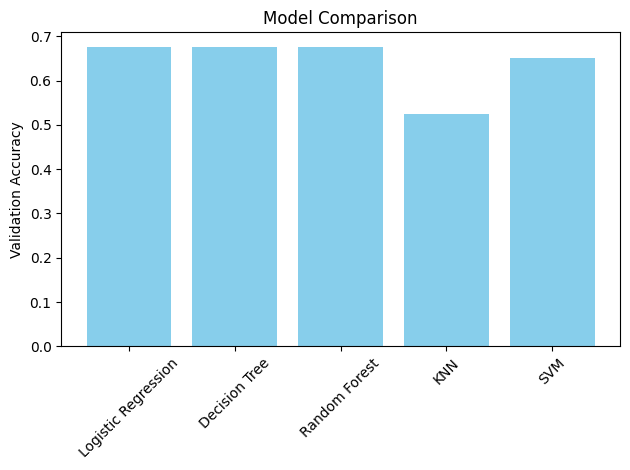


--- Model Predictions ---
Logistic Regression: REAL (98.71% margin confidence)
Decision Tree: REAL (100.00% margin confidence)
Random Forest: REAL (66.00% margin confidence)
KNN: REAL (20.00% margin confidence)
SVM: FAKE (4.50% margin confidence)


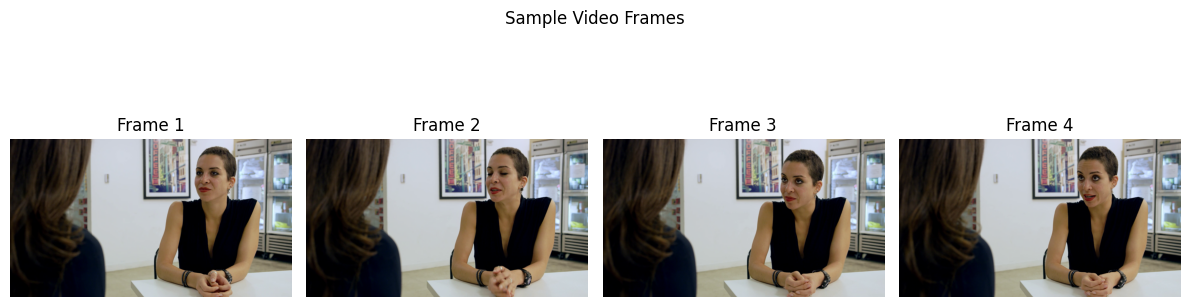

In [27]:
# MAIN
def main(train=True):
    if train:
        X, y = process_dataset()
        if len(X) == 0:
            print("No data processed.")
            return
        train_all_models(X, y)

    if os.path.exists(demo_vid):
        predict_video(demo_vid)
    else:
        print("Sample video not found.")

if __name__ == "__main__":
    main(train=True)  # Set train=False to skip training and only predict